# Minimal Steps to Recreate the entire Analysis

Take from the other workbooks  to get everything up and running quickly.

###### [Import Scripts]

In [44]:
%reload_ext autoreload
%autoreload 2
import jokedictfuncs as jdict

### 1. Scrape Data from Reddit and put into DB

This will parse all jokes in /r/jokes from the first entry (epoch: ~ 1.24e9) to now (epoch: ~ 1.58e9).

This takes about ~ 2 hours, so buckle up. 

Dont worry, if you rerun it it only updates from the last recorded epoch in the `log_epoch.txt` file.

In [31]:
rs = jdict.RedditStore()

==== RESIDENT
1587527186
1587563576
1587583091
1587606225
1587645221
1587665159
1587688300
1587722828
1587748451
1587771729
1587799187
1587830739
1587853780
1587881403
1587912310
1587933933
1587957535
1587993176
1588015915
1588040614
1588077773
1588101261
1588122862
1588155983
1588185890
1588208075
1588246136
1588271176
1588295352
1588327503
1588353515
1588377546
1588390418
1588429224
1588451189
1588480516
1588515593
1588542264
1588573100
1588600937
1588620776
1588643589
1588684551
1588708756
1588734450
1588769588
1588792437
1588821974
1588855404
Last epoch reached
1143479 threads


### 2. Finding Direct Duplicates / Reposts

A lot of jokes are literal reposts, others have a few word changes but are essentially just reposts.

Two things we can do:
  1. Collapse all identical jokes onto the same index and add a "repost" field (explored in 3_FindingDirectDuplicates.ipynb).
  2. Do nothing, and let the reposts become self evident in the clustering (i.e. they will occupy the same space)
  
 
 We will do 2 out of laziness.

### 3. Dimension Reduction and Embedding

K-means expects an initial K number, which we simply don't know with an unlabelled set like this, so we will use DBSCAN

First we need to create a flat array of data, and try to extract 1M features from it using the vectorizer

In [16]:
table, data = Inspect.flattenDatasets()

In [22]:
print("Observations:", len(table))
table[10000:10003]

Observations: 1143479


Data
id                                                      
srv81  just split up with my girlfriend who worked in...
srvv0  a british fellow just doesnt understand why pe...
srww5  so bubba j and bobby run into each other --- a...

This is pretty hefty set of features, and let's see if we can reduce to the top 100 with PCA, but we will use TruncatedSVD since it works better on sparse matrices.

Good, now let's perform the embedding with UMAP. Why UMAP? So we can incorporate more data later

In [6]:
X = jdict.Analysis.makeFeaturesIDF(data, max_features=10000, 
                          df_range=(2, 0.5), ngram_range=(2,3))

X_redux = jdict.Analysis.dimensionReduction(X, pca_components=50)

embedding = jdict.Analysis.perform2DEmbed(X_redux)

**Note:** This took approximately 24hrs to compute on a 16-core 2.4Ghz server with 120GB RAM.

In [ ]:
with open("save.pickle", "wb") as efile:
    pickle.dump([table, X_redux, embedding], efile)

*****

Resume analysis (run the below cell if you closed the session and need to resume)

In [ ]:
with open("save.pickle", "rb") as efile:
    table, X_redux, embedding = pickle.load(efile)

In [13]:
%reload_ext autoreload
%autoreload 2
from jokedictfuncs import *

with open("embedding.pickle", "rb") as efile:
    X_redux, embedding = pickle.load(efile)

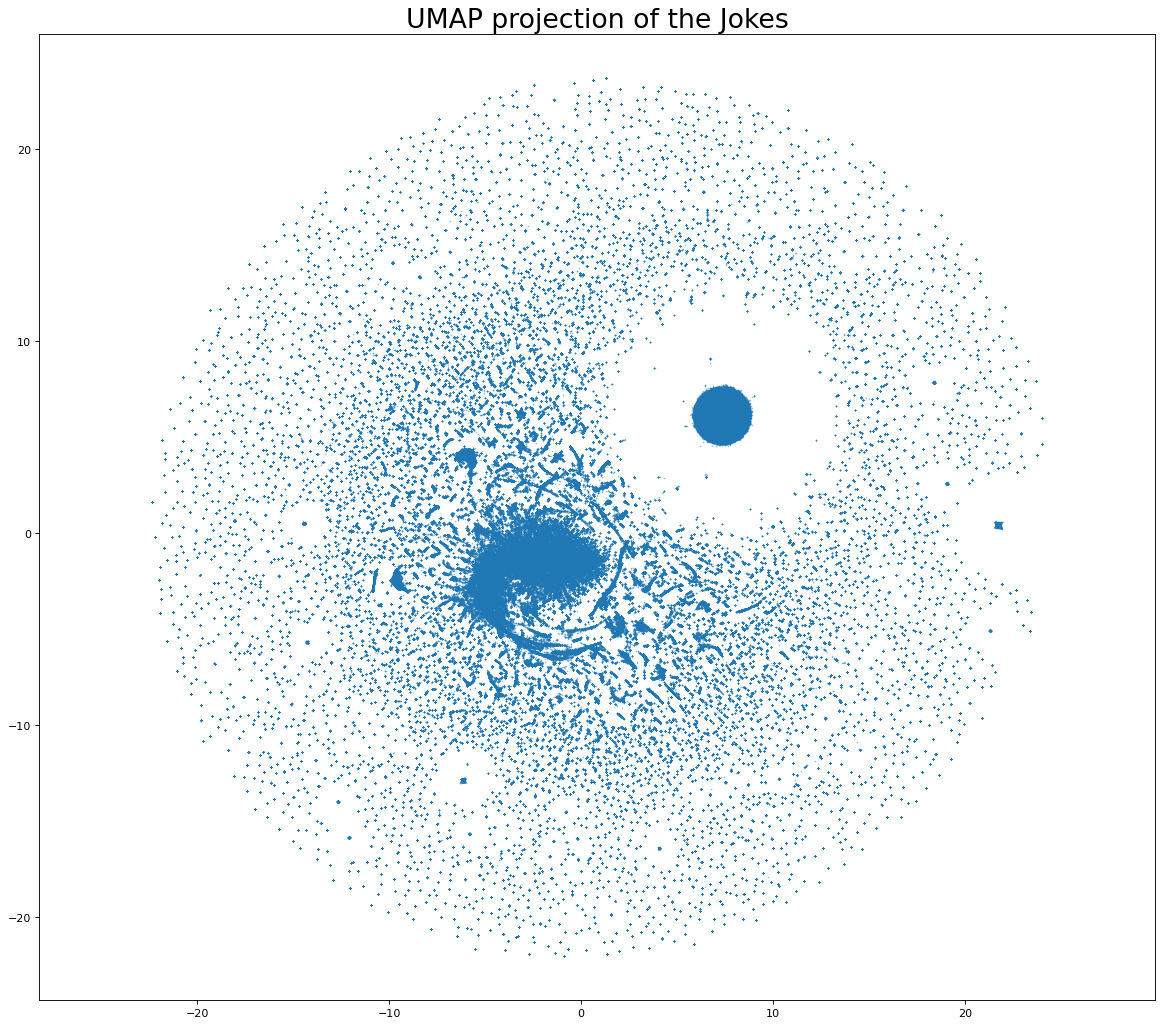

In [23]:
Analysis.plotEmbed(embedding, 'UMAP projection of the Jokes')

Nice let's zoom in to some sections

### 3. Zoomed in

#### Main Circle

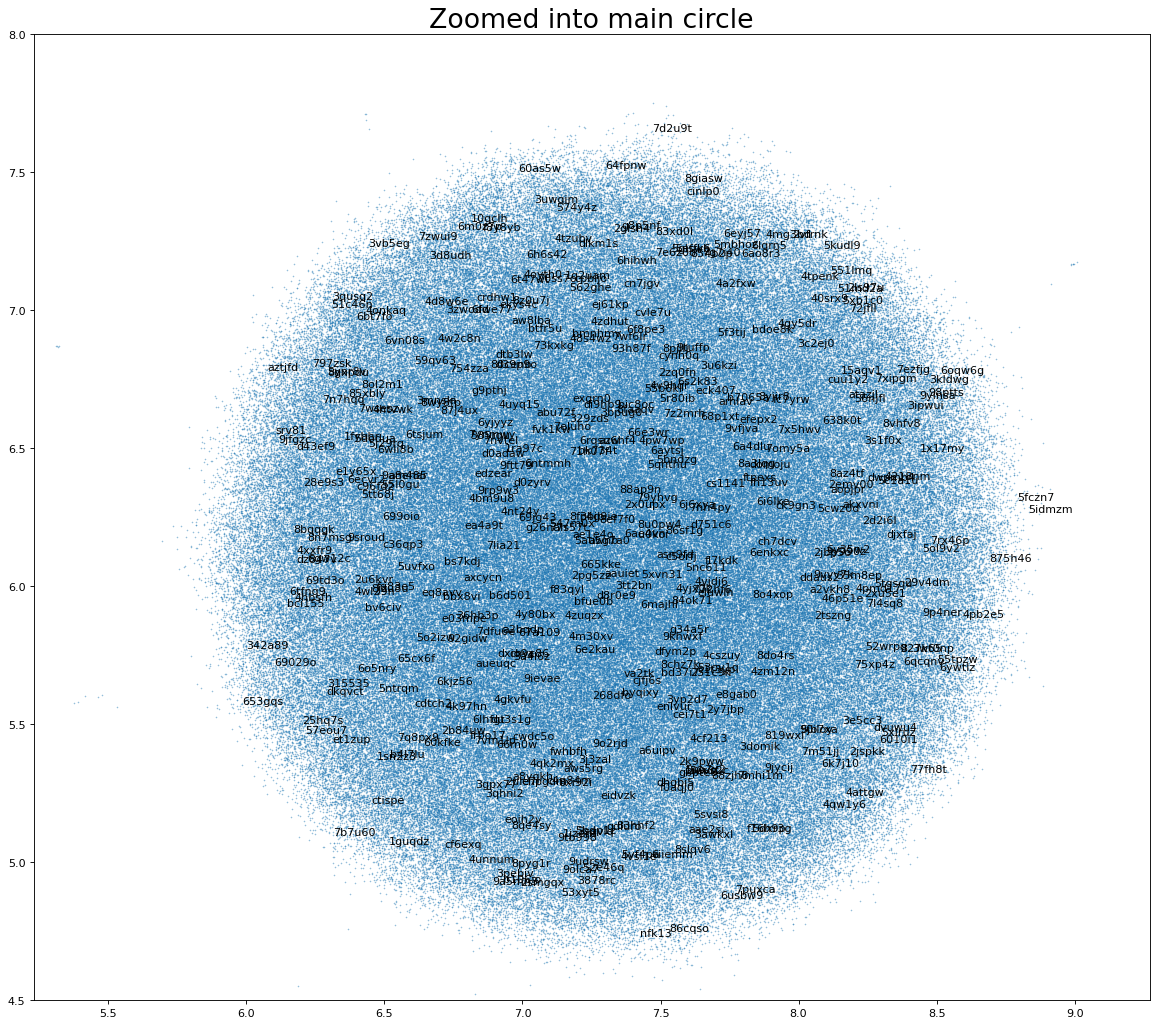

In [45]:
xlim=(5.5,9)
ylim=(4.5,8)

fig, ax = Analysis.plotEmbed(embedding, 'Zoomed into main circle', 
                             xlim=xlim, ylim=ylim)

jokes_in_region = Analysis.annotatePlot(ax, embedding, table, xlim, ylim)

Let's see if there is any pattern in there

In [46]:
jokes_in_region.tail(5)

Data
id                                                       
gf5g1f  this corona quarantine has given my wife alzhe...
gf5h8c  what is joe bidens favourite sportswear brand ...
gf5pxw  a sheep a drum and a snake fell off a cliff --...
gf5qte  what do you call your british communist friend...
gf5sun       every market in africa --- is a black market

No pattern I can see.... maybe that means subclustering is needed?

#### Spirally Region

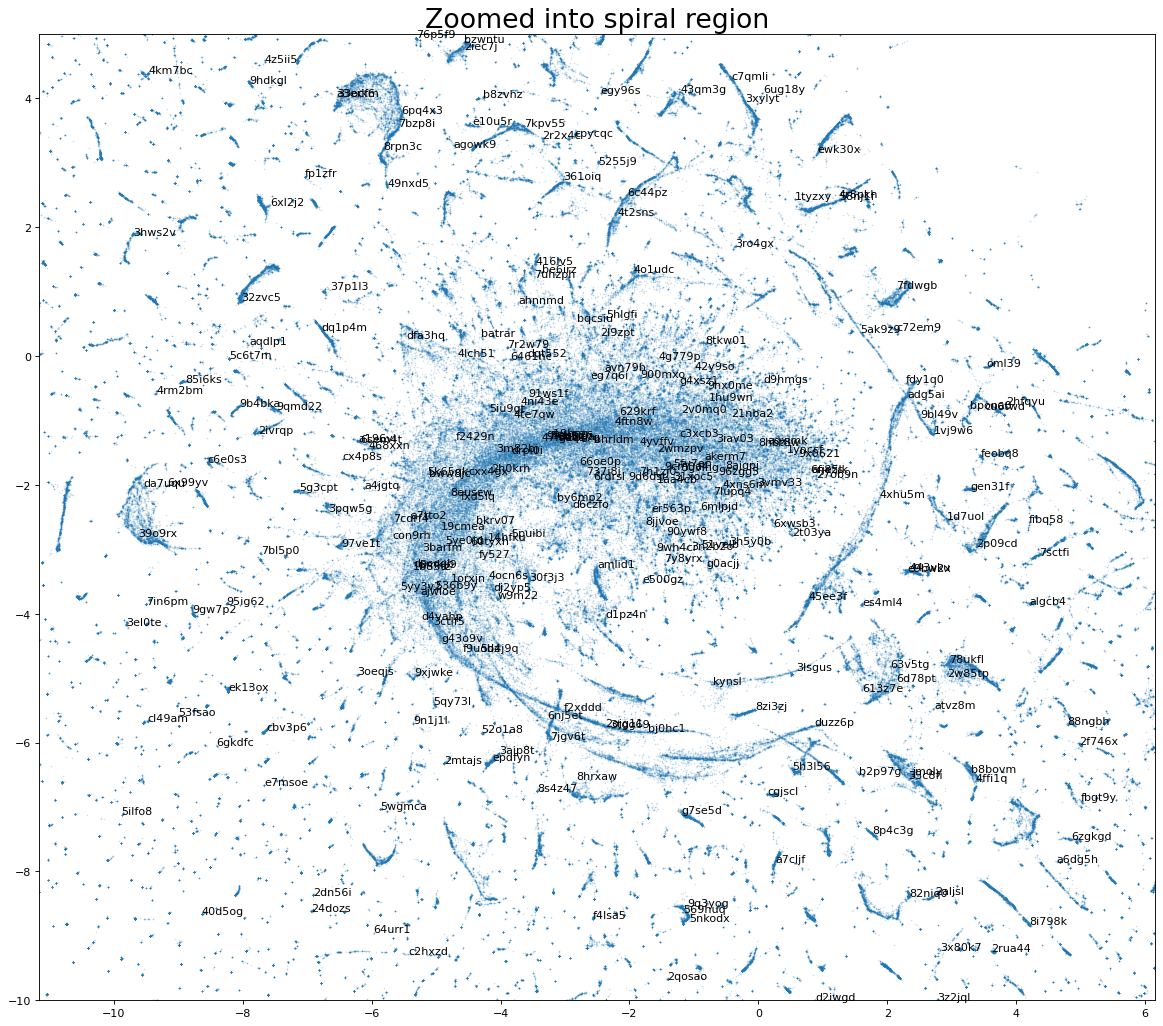

In [47]:
xlim=(-10,5)
ylim=(-10,5)

fig, ax = Analysis.plotEmbed(embedding, 'Zoomed into spiral region', 
                             xlim=xlim, ylim=ylim, point=0.01)

jokes_in_region = Analysis.annotatePlot(ax, embedding, table, xlim, ylim)

In [48]:
jokes_in_region.tail(5)

Data
id                                                       
gf4zr1  a reporter comes to slovakian tatra mountains ...
gf5jed  a guy was taking his year end final for his co...
gf5meu  whats worse than ants in your pants --- michae...
gf5r3f  why did the veterinarian get sent home early -...
gf5txx  og based on a true story my dad and i hopped i...

Still no real pattern. Let's try a teeny tiny region

#### Dense Dot

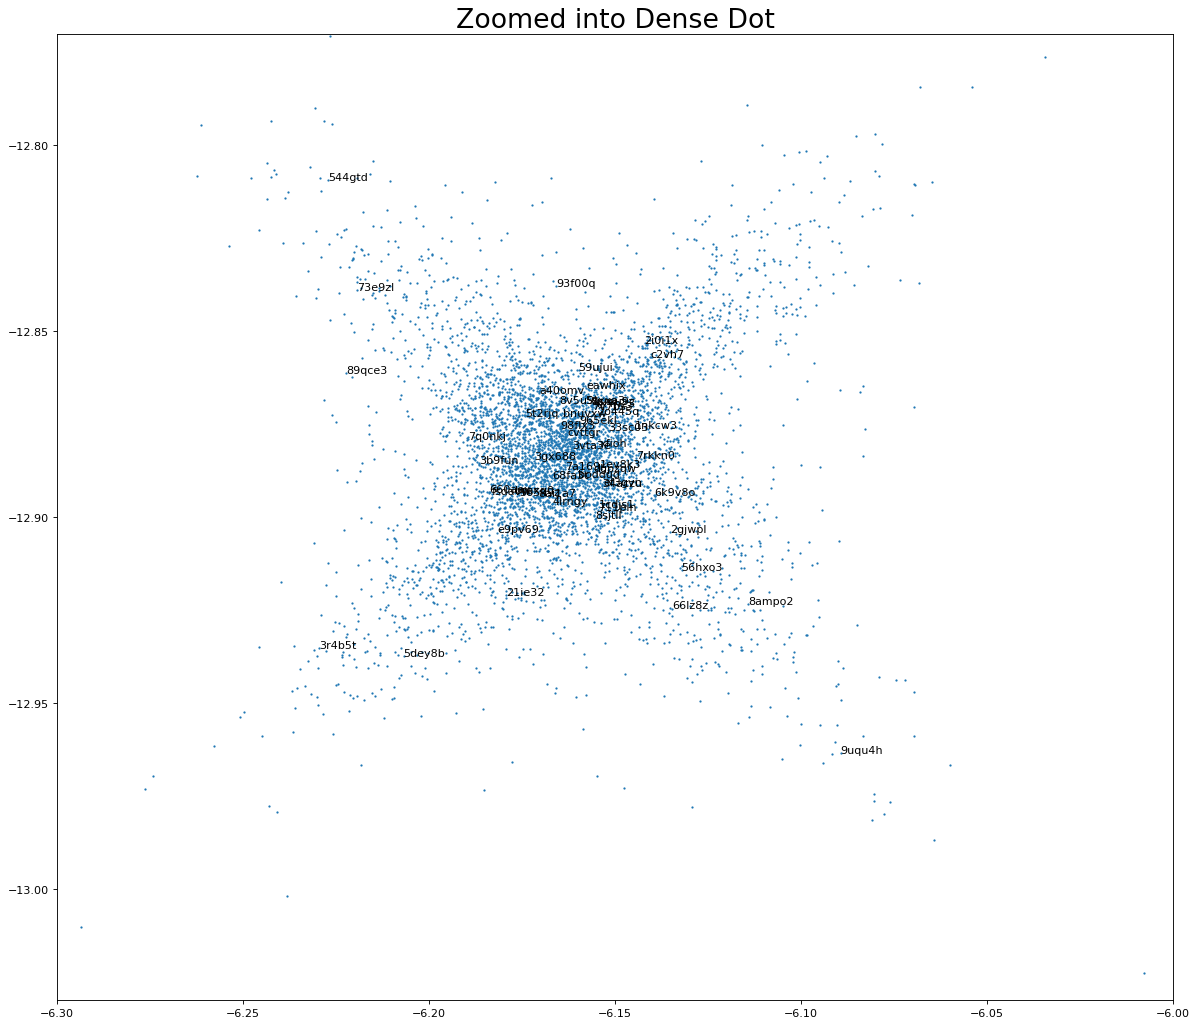

In [60]:
xlim=(-6.3,-6.0)
ylim=(-13.0,-12.8)

fig, ax = Analysis.plotEmbed(embedding, 'Zoomed into Dense Dot', 
                             xlim=xlim, ylim=ylim, point=1)

jokes_in_region = Analysis.annotatePlot(ax, embedding, table, xlim, ylim, 
                                        every=100)

In [61]:
jokes_in_region.tail(5)

Data
id                                                       
gecf2a  did you hear about the explosion at the nissan...
gejl9y  did you hear about the buddhist who refused no...
gembba  did you hear about murder hornets --- theyre t...
geypbh  did you hear the wild and exciting stories ita...
gf1yyk  did you hear about the dead atheist --- he was...

There we go, starting to see some similarity. Let's see another region

#### Small streak

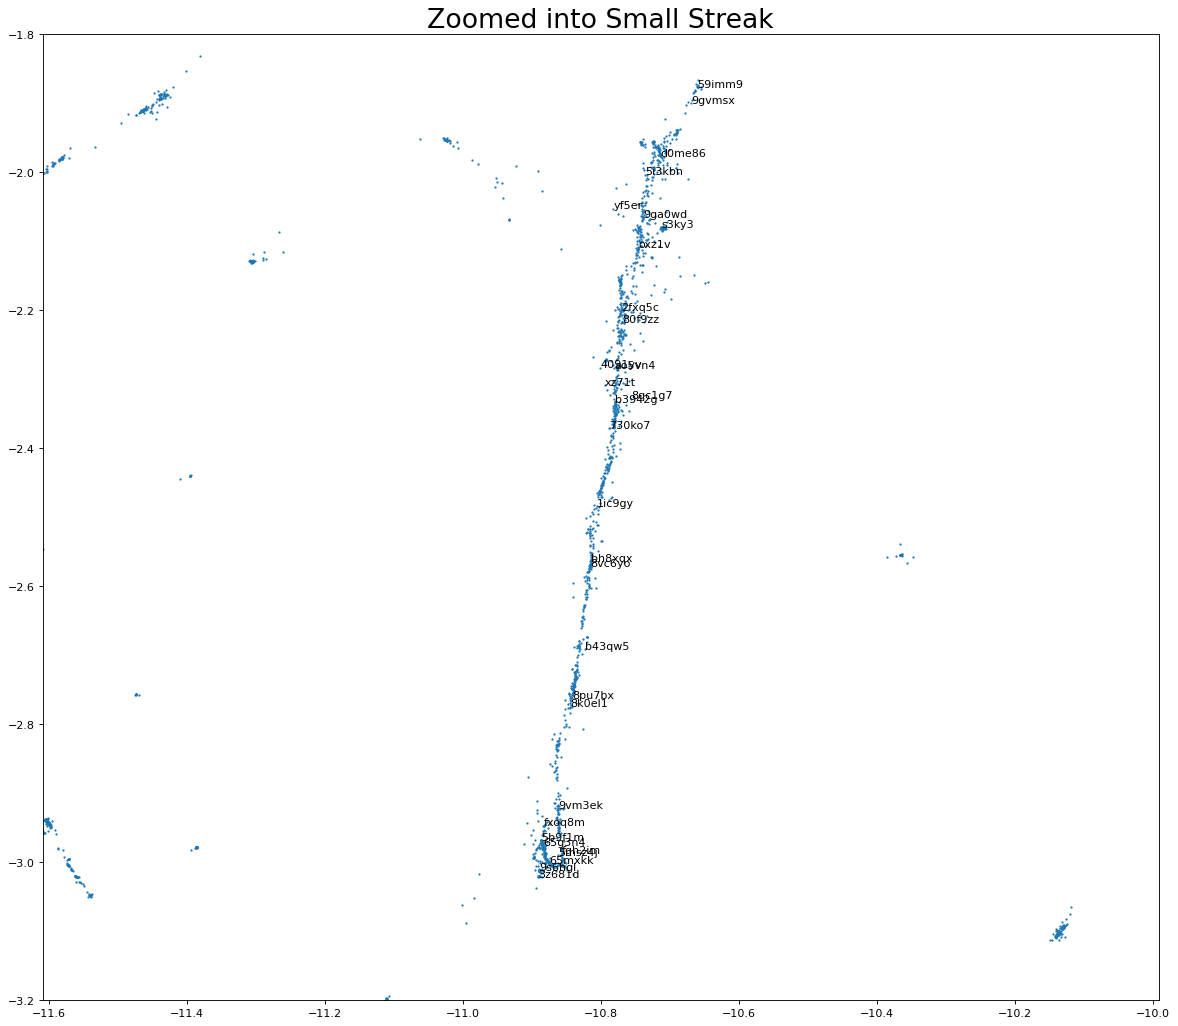

In [67]:
xlim=(-11.2,-10.4)
ylim=(-3.2,-1.8)

fig, ax = Analysis.plotEmbed(embedding, 'Zoomed into Small Streak', 
                             xlim=xlim, ylim=ylim, point=1)

jokes_in_region = Analysis.annotatePlot(ax, embedding, table, xlim, ylim, 
                                        every=45)

In [76]:
jokes_in_region.tail(10)

Data
id                                                       
gaoqoi  when i was in high school my high school emplo...
gb2wf0  when i was about 9 years old my father forced ...
gb34m1  a priest an irishman and a silver ladle --- an...
gbbc34  i didnt know what to wear to my premature ejac...
gbkh4c  how did hitler turn from failed artist into a ...
gblojc  i didnt know what time my premature ejaculatio...
gbsywn   you piece of shit go around my back and cheat...
gdy6j8  i asked my dad to hand me a newspaper --- he s...
geholl  i got kicked out of comiccon for assaulting a ...
gel57o  a guy was expecting a kid --- he and his wife ...

Nope, not very well clustered

### Clustering